# Imports


In [ ]:
!pip install pymysql

     |████████████████████████████████| 43 kB 769 kB/s 


In [ ]:
import pymysql #Mysql
import pandas as pd #Dataframe Operation
import numpy as np #calculation
import matplotlib.pyplot as plt #ploting
from datetime import date #date
import datetime
import seaborn as sns  #ploting
from datetime import datetime
from itertools import chain


In [ ]:

pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)

# Connection

In [ ]:
e='RDS link'
u='user name'
p='password'
db='daatabase LINK'
connection=pymysql.connect(host=e,user=u,passwd=p,db=db)

## Feching the User



In [ ]:
cursors2=connection.cursor()
cursors2.execute("""
select *,CONVERT_TZ(orders.accepted_at, '+00:00', '+5:00') As accepted_at_P from orders
inner join address
on orders.address_id=address.id
inner join service_area
on address.service_area_id=service_area.id
where is_order_fake=0 and orders.status=9;
""")
rows2=cursors2.fetchall()
data2=pd.DataFrame(rows2)
arra1=[]
for col in range(0,len(data2.columns)):
  arra1.append(cursors2.description[col][0])
arra1[5]='order_status'
arra1[72]='area_id'
data2.columns=arra1

## Fetching users not activated yet





In [ ]:
cursors2=connection.cursor()
cursors2.execute("""
select *,CONVERT_TZ(user.created_at, '+00:00', '+5:00') As created_at_p
from user
inner join address
on user.id=address.user_id
inner join service_area
on address.service_area_id=service_area.id
where user.role_id=3 and user.id not in (select customer_id from orders) and CONVERT_TZ(user.created_at, '+00:00', '+5:00')<  now() - interval 24 hour;
""")
rows2=cursors2.fetchall()
user_never_order=pd.DataFrame(rows2)
arra1=[]
for col in range(0,len(user_never_order.columns)):
  arra1.append(cursors2.description[col][0])
user_never_order.columns=arra1

# Completion Graph

In [ ]:
cursors=connection.cursor()
cursors.execute("""select *,date_format(CONVERT_TZ(orders.created_at, '+00:00', '+5:00'), '%h %p') As Hour from orders
inner join address
on orders.address_id=address.id
inner join service_area
on address.service_area_id=service_area.id
where CONVERT_TZ(orders.created_at, '+00:00', '+5:00') >=  now() - interval 24 hour and orders.is_order_fake=0;
""")


2133

In [ ]:
rows=cursors.fetchall()
data=pd.DataFrame(rows)
arra=[]
for col in range(0,len(data.columns)):
  arra.append(cursors.description[col][0])
arra[5]='order_status'
data.columns=arra
time=[]
Total_order=[]
completed_order=[]
service_area=[]

In [ ]:

for area in data['service_area_id'].unique():
  for val in data['Hour'].unique():
    service_area.append(area)
    time.append(val)
    Total_order.append(data[(data['Hour']==val) & (data['service_area_id']==area)].count()[1])
    completed_order.append(data[(data['order_status']==9) & (data['Hour']==val)  & (data['service_area_id']==area)].count()[1])
time=np.array(time)
Total_order=np.array(Total_order)

completed_order=np.array(completed_order)
service_area=np.array(service_area)


In [ ]:
Output=pd.DataFrame()
Output['Time']=time
Output['service_area']=service_area
Output['Total_order']=Total_order
Output['completed_order']=completed_order
Output['per_order_complete']=round(Output['completed_order']*100/Output['Total_order'])


In [ ]:
Output=Output.fillna(-1)
Output['per_order_complete']=Output['per_order_complete'].astype('Int64')

In [ ]:

cohort_pivot = Output.pivot_table(index = 'Time',
                                     columns = 'service_area',
                                     values = 'per_order_complete')

In [ ]:
Output.shape

(416, 5)

In [ ]:
cohort_pivot.shape

(16, 26)

In [ ]:
cohort_pivot=cohort_pivot.dropna()

In [ ]:
cohort_pivot

service_area,11,13,26,10002,10016,10017,10023,10026,10027,10028,10034,10038,10040,10042,10043,10044,10047,10048,10049,10051,10052,10053,10058,10059,10060,10061
Time,,,,,,,,,,,,,,,,,,,,,,,,,,
01 AM,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
01 PM,100,75,-1,33,33,100,75,-1,100,100,67,88,100,-1,-1,100,-1,100,75,75,73,67,100,100,75,-1
02 PM,86,86,29,75,100,0,93,100,100,-1,100,74,80,-1,50,100,50,-1,80,100,67,100,81,89,100,80
03 PM,77,38,96,50,100,100,80,0,68,100,64,73,80,-1,67,42,-1,50,100,57,67,72,78,100,64,50
04 PM,60,50,100,50,75,50,72,75,64,100,62,50,100,100,-1,100,75,100,50,60,100,83,86,100,100,100
05 PM,100,90,100,50,33,0,80,-1,100,-1,82,77,50,-1,0,50,100,67,80,83,75,-1,100,100,88,-1
06 PM,83,78,100,50,100,-1,89,-1,100,0,80,100,100,-1,100,100,-1,100,75,100,67,100,92,56,91,-1
07 PM,100,91,100,100,100,-1,100,-1,100,100,75,62,100,-1,0,100,100,50,-1,71,100,100,100,100,62,-1
08 PM,80,92,95,0,100,100,-1,100,92,-1,60,90,100,-1,-1,50,75,100,86,86,86,-1,100,100,-1,-1


In [ ]:
cohort_pivot=cohort_pivot/100

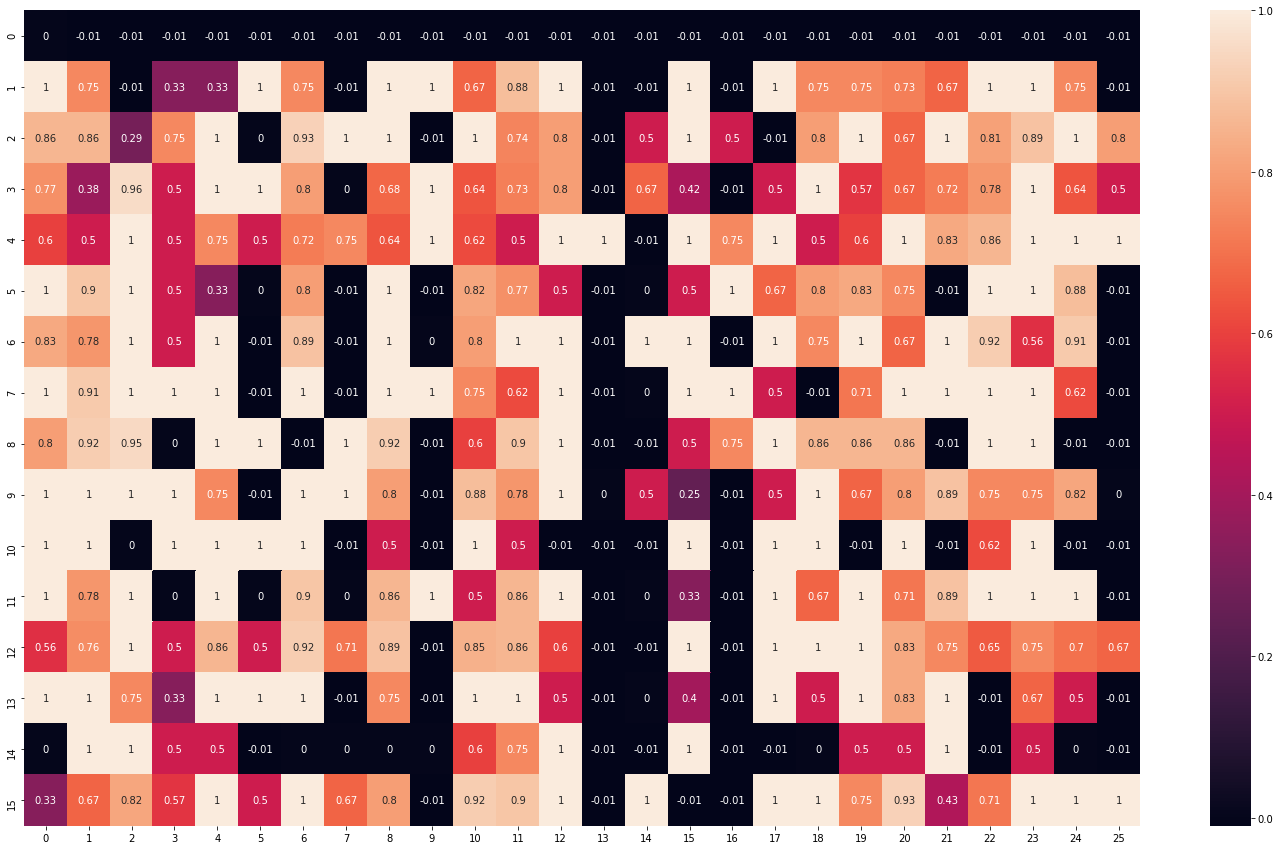

In [ ]:
plt.figure(figsize=(25,15))
sns.heatmap(cohort_pivot.to_numpy(),annot=True)
plt.show()

In [ ]:
def color_negative_red(value):
  """
  Colors elements in a dateframe
  green if positive and red if
  negative. Does not color NaN
  values.
  """
  if ((value < 30) & (value >= 0)):
    color = 'red'
  elif value > 30:
    color = 'green'
  else:
    color = 'blue'

  return 'color: %s' % color
th_props = [
  ('font-size', '19px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9'),
  ( 'margin', '400px'),

  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),

  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]
Output3=cohort_pivot.style.applymap(color_negative_red).format({'total_amt_usd_pct_diff': "{:.2%}"}).set_table_styles(styles)


In [ ]:
Output3

service_area,11,13,26,10002,10016,10017,10023,10026,10027,10028,10034,10038,10040,10042,10043,10044,10047,10048,10049,10051,10052,10053,10058,10059,10060,10061
Time,,,,,,,,,,,,,,,,,,,,,,,,,,
01 AM,0.000000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000
01 PM,1.000000,0.750000,-0.010000,0.330000,0.330000,1.000000,0.750000,-0.010000,1.000000,1.000000,0.670000,0.880000,1.000000,-0.010000,-0.010000,1.000000,-0.010000,1.000000,0.750000,0.750000,0.730000,0.670000,1.000000,1.000000,0.750000,-0.010000
02 PM,0.860000,0.860000,0.290000,0.750000,1.000000,0.000000,0.930000,1.000000,1.000000,-0.010000,1.000000,0.740000,0.800000,-0.010000,0.500000,1.000000,0.500000,-0.010000,0.800000,1.000000,0.670000,1.000000,0.810000,0.890000,1.000000,0.800000
03 PM,0.770000,0.380000,0.960000,0.500000,1.000000,1.000000,0.800000,0.000000,0.680000,1.000000,0.640000,0.730000,0.800000,-0.010000,0.670000,0.420000,-0.010000,0.500000,1.000000,0.570000,0.670000,0.720000,0.780000,1.000000,0.640000,0.500000
04 PM,0.600000,0.500000,1.000000,0.500000,0.750000,0.500000,0.720000,0.750000,0.640000,1.000000,0.620000,0.500000,1.000000,1.000000,-0.010000,1.000000,0.750000,1.000000,0.500000,0.600000,1.000000,0.830000,0.860000,1.000000,1.000000,1.000000
05 PM,1.000000,0.900000,1.000000,0.500000,0.330000,0.000000,0.800000,-0.010000,1.000000,-0.010000,0.820000,0.770000,0.500000,-0.010000,0.000000,0.500000,1.000000,0.670000,0.800000,0.830000,0.750000,-0.010000,1.000000,1.000000,0.880000,-0.010000
06 PM,0.830000,0.780000,1.000000,0.500000,1.000000,-0.010000,0.890000,-0.010000,1.000000,0.000000,0.800000,1.000000,1.000000,-0.010000,1.000000,1.000000,-0.010000,1.000000,0.750000,1.000000,0.670000,1.000000,0.920000,0.560000,0.910000,-0.010000
07 PM,1.000000,0.910000,1.000000,1.000000,1.000000,-0.010000,1.000000,-0.010000,1.000000,1.000000,0.750000,0.620000,1.000000,-0.010000,0.000000,1.000000,1.000000,0.500000,-0.010000,0.710000,1.000000,1.000000,1.000000,1.000000,0.620000,-0.010000
08 PM,0.800000,0.920000,0.950000,0.000000,1.000000,1.000000,-0.010000,1.000000,0.920000,-0.010000,0.600000,0.900000,1.000000,-0.010000,-0.010000,0.500000,0.750000,1.000000,0.860000,0.860000,0.860000,-0.010000,1.000000,1.000000,-0.010000,-0.010000


# New User

## Calculate time of users who are not activated yet


In [ ]:
user_never_order['Time']=datetime.now()-user_never_order['created_at_p']

## Rank in desending



In [ ]:
user_never_order['percential']=user_never_order['Time'].rank(pct=True,ascending=False)

In [ ]:
user_never_order.sort_values('percential',inplace=True,ascending=False)

In [ ]:
user_never_order.head()

,id,user_uuid,name,email,phone,role_id,locale_id,created_at,updated_at,password,is_active,avatar,phone_verified,device_token,sign_up_type,is_password_set,balance,organization_id,signup_discount_count,device_type,device_id,social_account_id,is_email_invitation_received,is_email_verified,inactive_comment,inactive_reason_id,id,user_id,location_name,poi,address,city_id,latitude,longitude,status,additional_details,service_area_id,created_at,updated_at,updated_by,created_by,id,name,city_id,geofence,is_active,dispatch_algo_id,dispatch_radius,sort_type,operational_time_msg,created_at,updated_at,created_by,updated_by,area_id,created_at_p,Time,percential
9154,206383,None,Shahid Shahid,shahid2186703@gmail.com,+923367448561,3,1,2021-08-29 05:35:51,2021-08-29 05:42:49,{bcrypt}null,1,profile-picture/1630215360387-profile-picture.,1,c5PtM5yIRlmDm-6PzhDQDY:APA91bG7yUuOfMqp_d9RMR1...,GOOGLE,0,0.0,None,0,None,a31a61080395528f,None,0,NaN,None,NaN,123078,206383,Home,W3W2+MM7,Block L North Nazimabad Town,None,24.946669,67.051664,1,hous no 66 chá gellaw wala lahore,10052,2021-08-29 08:25:06,2021-08-29 08:25:06,206383.0,206383.0,10052,North Nazimabad & FB Area,1,"[{""x"":24.94246836909784,""y"":67.03299564704865}...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:45:16,2021-08-24 06:51:32,24673.0,15000.0,10.0,2021-08-29 10:35:51,1 days 00:32:23.598307,1.000000
9151,206377,None,Anas Ladka,anasladka401@gmail.com,+923102847479,3,1,2021-08-29 05:32:02,2021-08-29 05:33:01,{bcrypt}null,1,profile-picture/1630215126244-profile-picture.,1,fiTsia7HTXeYx_xnmRsxFw:APA91bHgWnbyPEyHnuGA5wb...,GOOGLE,0,0.0,None,0,None,611eb6891fcef7d5,None,0,NaN,None,NaN,123054,206377,Home,Plot ST 5,Block M North Nazimabad Town,None,24.947559,67.053462,1,anasladka401@gmail.com,10052,2021-08-29 05:36:24,2021-08-29 05:36:24,206377.0,206377.0,10052,North Nazimabad & FB Area,1,"[{""x"":24.94246836909784,""y"":67.03299564704865}...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:45:16,2021-08-24 06:51:32,24673.0,15000.0,10.0,2021-08-29 10:32:02,1 days 00:36:12.598307,0.999891
9150,206359,None,rabia younus,rabiayounus87@gmail.com,+923323588776,3,1,2021-08-29 04:54:08,2021-08-29 04:54:39,{bcrypt}null,1,profile-picture/1630212848676-profile-picture.,1,f4drmlOdTQ2b_m9Dw1Z9NJ:APA91bEPXzkJmjPh2JJuOFr...,GOOGLE,0,0.0,None,0,None,e1dff1fb03eff6de,None,0,NaN,None,NaN,123053,206359,Home,Plot A 77,Block P North Nazimabad Town,None,24.935092,67.027172,1,A 76 block P hussain dsilva town North nazimab...,10051,2021-08-29 05:05:52,2021-08-29 05:05:52,206359.0,206359.0,10051,Nazimabad Larger Zone,1,"[{""x"":24.9299669143097,""y"":67.05207591617797},...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:39:02,2021-08-24 06:53:22,24673.0,15000.0,4.0,2021-08-29 09:54:08,1 days 01:14:06.598307,0.999782
9147,206352,None,Rizwan Liaquat,rizoo1122@gmail.com,+923002420238,3,1,2021-08-29 04:10:29,2021-08-29 04:10:57,{bcrypt}null,1,profile-picture/1630210236572-profile-picture.,1,ftbwNrJhQgSFPWEaCPNCKV:APA91bFK3eIavNtZC7VPUrV...,GOOGLE,0,0.0,None,0,None,a994c15c15760b92,None,0,NaN,None,NaN,123050,206352,Home,Shahrah-e-Usman,"68 Shahrah-e-Usman, Sector 11-C/1 Sector 11 C ...",None,24.968094,67.066257,1,16 Han ji gfc nj,10034,2021-08-29 04:12:00,2021-08-29 04:12:00,206352.0,206352.0,10034,North Karachi & Bufferzone,1,"[{""x"":24.97881636288531,""y"":67.0538929422144},...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-01-01 19:36:12,2021-08-09 17:41:43,NaN,146550.0,12.0,2021-08-29 09:10:29,1 days 01:57:45.598307,0.999673
9143,206285,None,Maria Rehman,mariarehman2003@gmail.com,+923332992233,3,1,2021-08-29 00:47:09,2021-08-29 00:47:46,{bcrypt}null,1,profile-picture/1630198029733-profile-picture.,1,embtHaLMRfSr4DmxD_7pZk:APA91bHQI7Hq4yMqdaj2Ov-...,GOOGLE,0,0.0,None,0,None,7eebc1911ddaa19b,None,0,NaN,None,NaN,123044,206285,Home,Plot 256 A,Pakistan E

## User not activated yet - Days since download (higher the days, lower the score)

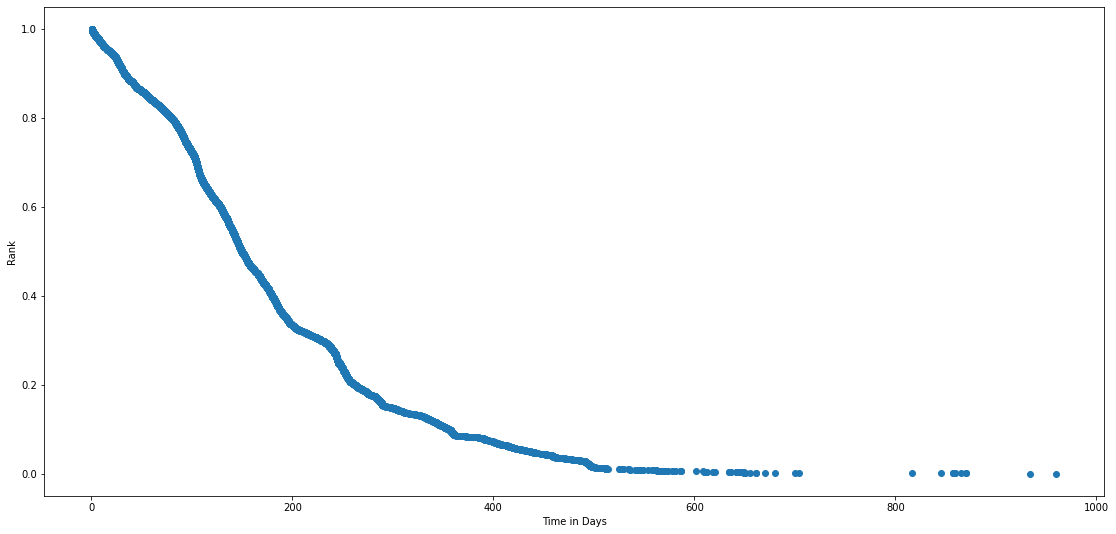

In [ ]:
plt.figure(figsize=(19,9))
a=user_never_order['Time'].astype('timedelta64[D]')
plt.scatter(a,user_never_order['percential'])
plt.xlabel('Time in Days')
plt.ylabel('Rank')
plt.show()

# Retention Cohort


## Completed Order

In [ ]:
complete=data2[data2['order_status']==9]


## Exclude users with Null as order accepted time


In [ ]:
complete.dropna(axis=0,subset=['accepted_at'],inplace=True)


## Calculate the time of User's Last Successful Order

In [ ]:
max_date = max(complete['accepted_at_P'])
complete['Time']=max_date-complete['accepted_at_P']


## Calculate the last time Order

In [ ]:
User_recency=complete.loc[complete.groupby("customer_id")["Time"].idxmin()]

## Retention Cohort - User with a successful order in last 30 days


In [ ]:
fisrt_thirty_data=User_recency[User_recency['Time']<='30 days']
fisrt_thirty_data['Percential']=fisrt_thirty_data['Time'].rank(pct=True)
fisrt_thirty_data['rececy_Percential']=fisrt_thirty_data['Time'].rank(pct=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Graph

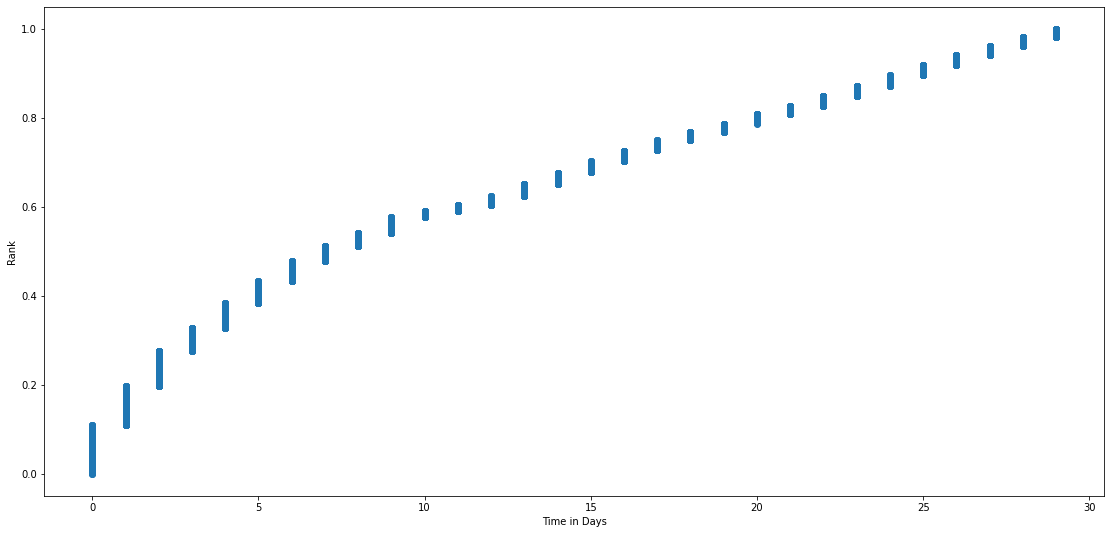

In [ ]:
plt.figure(figsize=
           (19,9))
a=fisrt_thirty_data['Time'].astype('timedelta64[D]')
plt.scatter(a,fisrt_thirty_data['rececy_Percential'])
plt.xlabel('Time in Days')
plt.ylabel('Rank')
plt.show()

## Calculate Frequency and Rank Them

In [ ]:
#Frequency of all user:
complete2=data2[data2['order_status']==9]
complete2.dropna(axis=0,subset=['accepted_at'],inplace=True)
complete2['freq'] = complete2.groupby('customer_id')['total'].transform('count')
frquency_data=complete2
frquency_data.drop_duplicates(subset ="customer_id",keep = 'first', inplace = True)
frquency_data.sort_values('freq',inplace=True)


## Joining the last 30 days and their frequency

In [ ]:
recency_frequecy_data = pd.merge(left=fisrt_thirty_data, right=frquency_data, how='inner', left_on='customer_id', right_on='customer_id')


## Graph

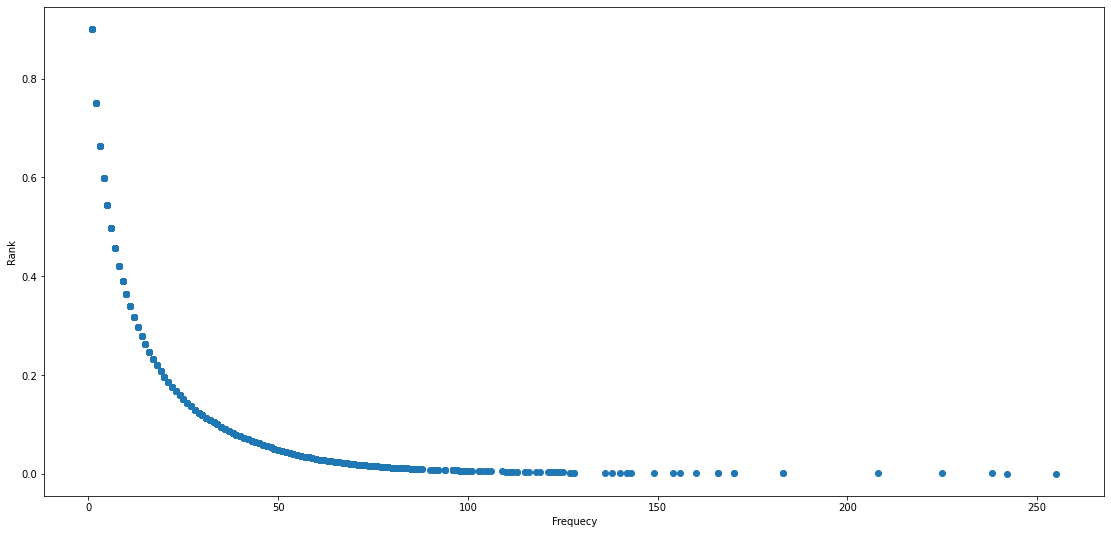

In [ ]:
recency_frequecy_data['Percential_freq']=recency_frequecy_data['freq'].rank(pct=True,ascending=False)
plt.figure(figsize=(19,9))
plt.scatter(recency_frequecy_data['freq'],recency_frequecy_data['Percential_freq'])
plt.xlabel('Frequecy')
plt.ylabel('Rank')
plt.show()

## Final Rank


1.   Recency * 0.80 + frequency * 0.20



In [ ]:
recency_frequecy_data['reatation Time']=recency_frequecy_data['Time']
recency_frequecy_data['reatation Percential']=recency_frequecy_data['Percential']
recency_frequecy_data['freq User']=recency_frequecy_data['freq']
recency_frequecy_data['frequency percential']=recency_frequecy_data['Percential_freq']
recency_frequecy_data['Final Percential']=recency_frequecy_data['reatation Percential']*0.8+recency_frequecy_data['frequency percential']*0.20
recency_frequecy_data.sort_values('Final Percential',inplace=True,ascending=False)

In [ ]:
recency_frequecy_data.head()

,id_x,is_order_fake_x,created_at_x,updated_at_x,reference_id_x,order_status_x,order_type_x,delivery_type_x,delivery_time_x,is_swappable_x,partial_order_acceptable_x,payment_type_x,customer_id,hub_id_x,buddy_id_x,buddy_assigned_by_x,address_id_x,cancellation_id_x,cancelled_at_x,dispatched_at_x,delivered_at_x,rating_x,delivery_instruction_x,promo_code_id_x,sub_total_x,total_x,delivery_x,convenience_x,discount_x,discount_type_x,remarks_x,contact_person_name_x,contact_person_phone_x,amount_received_x,near_by_hub_id_x,accepted_at_x,is_delivery_charges_waived_off_x,waived_off_charges_x,distance_in_meters_x,time_in_seconds_x,reached_hub_at_x,reached_customer_at_x,order_collected_at_x,free_delivery_promo_code_id_x,receipt_image_url_x,customer_feedback_x,buddy_feedback_x,skip_rating_count_x,online_payment_id_x,initial_eta_in_minutes_x,distance_in_km_x,online_payment_amount_x,app_agent_x,discounted_sub_total_x,created_by_x,updated_by_x,retry_order_count_x,is_assistance_required_x,assistance_required_at_x,id_x,user_id_x,location_name_x,poi_x,address_x,city_id_x,latitude_x,longitude_x,status_x,additional_details_x,service_area_id_x,created_at_x,updated_at_x,area_id_x,created_by_x,id_x,name_x,city_id_x,geofence_x,is_active_x,dispatch_algo_id_x,dispatch_radius_x,sort_type_x,operational_time_msg_x,created_at_x,updated_at_x,created_by_x,updated_by_x,area_id_x,accepted_at_P_x,Time,Percential,rececy_Percential,id_y,is_order_fake_y,created_at_y,updated_at_y,reference_id_y,order_status_y,order_type_y,delivery_type_y,delivery_time_y,is_swappable_y,partial_order_acceptable_y,payment_type_y,hub_id_y,buddy_id_y,buddy_assigned_by_y,address_id_y,cancellation_id_y,cancelled_at_y,dispatched_at_y,delivered_at_y,rating_y,delivery_instruction_y,promo_code_id_y,sub_total_y,total_y,delivery_y,convenience_y,discount_y,discount_type_y,remarks_y,contact_person_name_y,contact_person_phone_y,amount_received_y,near_by_hub_id_y,accepted_at_y,is_delivery_charges_waived_off_y,waived_off_charges_y,distance_in_meters_y,time_in_seconds_y,reached_hub_at_y,reached_customer_at_y,order_collected_at_y,free_delivery_promo_code_id_y,receipt_image_url_y,customer_feedback_y,buddy_feedback_y,skip_rating_count_y,online_payment_id_y,initial_eta_in_minutes_y,distance_in_km_y,online_payment_amount_y,app_agent_y,discounted_sub_total_y,created_by_y,updated_by_y,retry_order_count_y,is_assistance_required_y,assistance_required_at_y,id_y,user_id_y,location_name_y,poi_y,address_y,city_id_y,latitude_y,longitude_y,status_y,additional_details_y,service_area_id_y,created_at_y,updated_at_y,area_id_y,created_by_y,id_y,name_y,city_id_y,geofence_y,is_active_y,dispatch_algo_id_y,dispatch_radius_y,sort_type_y,operational_time_msg_y,created_at_y,updated_at_y,created_by_y,updated_by_y,area_id_y,accepted_at_P_y,freq,Percential_freq,reatation Time,reatation Percential,freq User,frequency percential,Final Percential
8895,761268,0,2021-07-31 11:10:42,2021-08-03 10:15:28,TXC9ND,9,NORMAL,NOW,NaT,1,1,1,191203,5449.0,1266.0,None,113976,NaN,NaT,2021-07-31 11:10:43,2021-07-31 11:39:20,5.0,call me,2.0,335.0,385.0,50.0,0.0,150.0,2.0,None,haris zahid,+923486482301,235.0,NaN,2021-07-31 11:10:49,b'\x00',0.0,NaN,0.0,2021-07-31 11:12:34,2021-07-31 11:37:58,2021-07-31 11:13:31,NaN,receipt/1627730013617-receipt.jpg,None,None,NaN,NaN,NaN,NaN,NaN,101-7.0-Customer-4.7.3,335.0,191203.0,191203.0,1.0,0,NaT,113976,191203,Home,Plot B 180,Qabail Colony Block 11 Gulberg Town,NaN,24.937302,67.060956,1,house no b181,10052,2021-07-31 10:56:56,2021-07-31 10:56:56,191203.0,191203.0,10052,North Nazimabad & FB Area,1,"[{""x"":24.94246836909784,""y"":67.03299564704865}...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:45:16,2021-08-24 06:51:32,24673.0,15000.0,10.0,2021-07-31 16:10:49,29 days 23:42:56,0.999733,0.999733,761268,0,2021-07-31 11:10:42,2021-08-03 10:15:28,TXC9ND,9,NORMAL,NOW,NaT,1,1,1,5449.0,1266.0,None,113976,NaN,NaT,2021-07-31 11:10:43,2021-07-31 11:39:20,5.0,call me,2.0,335.0,38

# Reactivation

## 30+ days Users Rank

In [ ]:
above_thirty=User_recency[User_recency['Time']>'30 days']
above_thirty['Percential']=above_thirty['Time'].rank(pct=True,ascending=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Graph

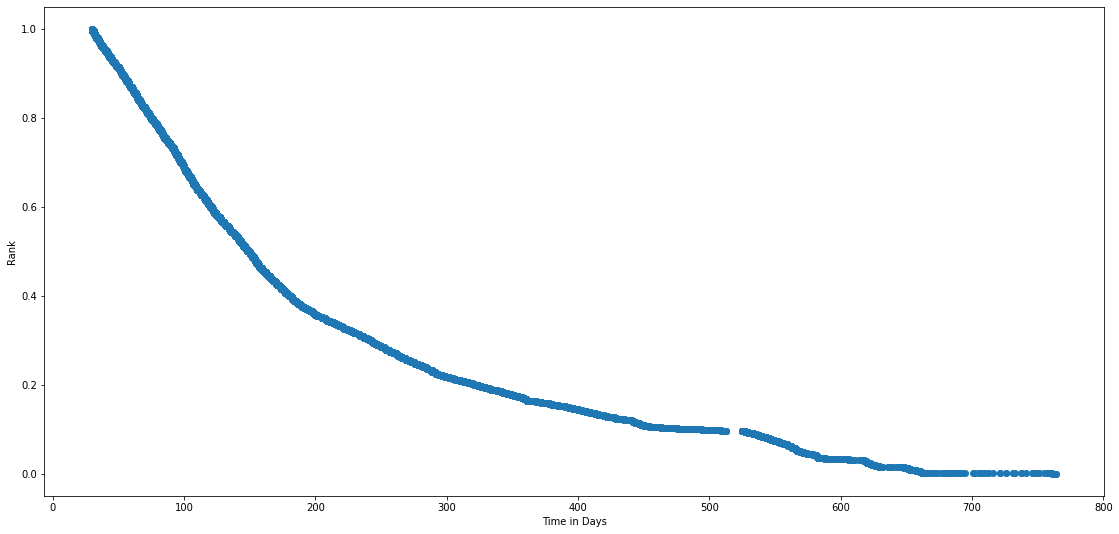

In [ ]:
plt.figure(figsize=
           (19,9))
a=above_thirty['Time'].astype('timedelta64[D]')
plt.scatter(a,above_thirty['Percential'])
plt.xlabel('Time in Days')
plt.ylabel('Rank')
plt.show()

## Join Then and Rank Them


In [ ]:
reactivation_frequency = pd.merge(left=above_thirty, right=frquency_data, how='inner', left_on='customer_id', right_on='customer_id')
reactivation_frequency['Percential_freq']=reactivation_frequency['freq'].rank(pct=True,ascending=True)


## Graph of frequency

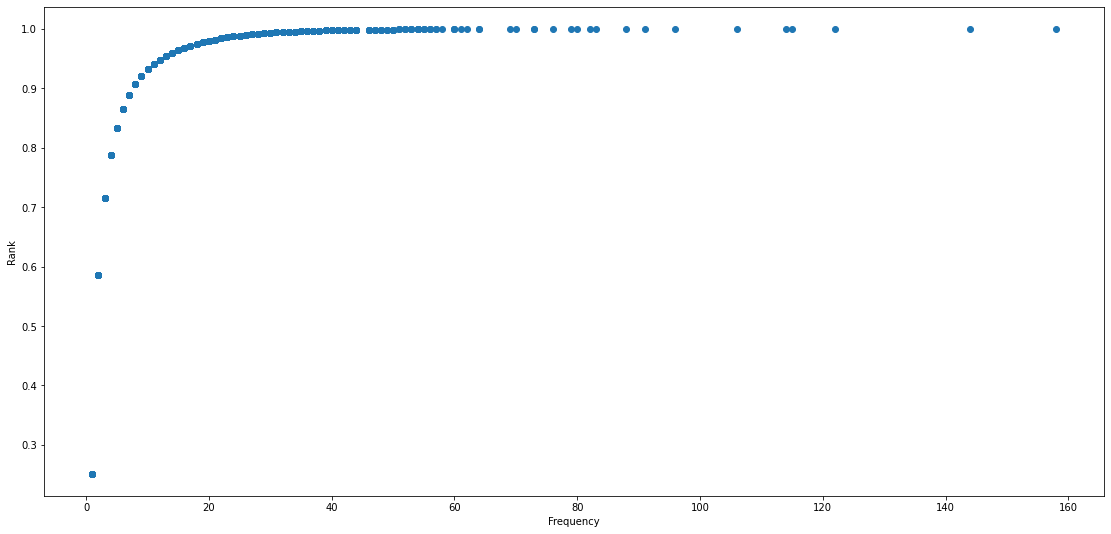

In [ ]:
plt.figure(figsize=(19,9))
plt.scatter(reactivation_frequency['freq'],reactivation_frequency['Percential_freq'])
plt.xlabel('Frequency')
plt.ylabel('Rank')
plt.show()

## Compute final Rank and Sort them:


1.   time * 0.50 + frequency * 0.50



In [ ]:
reactivation_frequency['reatation Time']=reactivation_frequency['Time']
reactivation_frequency['reatation Percential']=reactivation_frequency['Percential']
reactivation_frequency['freq User']=reactivation_frequency['freq']
reactivation_frequency['frequency percential']=reactivation_frequency['Percential_freq']
reactivation_frequency['Final Percential']=reactivation_frequency['reatation Percential']*0.50+reactivation_frequency['frequency percential']*0.50
reactivation_frequency.sort_values('Final Percential',inplace=True,ascending=False)

# Invite Users

## Fetch Data

In [ ]:
cursors3=connection.cursor()
cursors3.execute("""

select
BuddyData.Zone,
sename As service_area_name,
ABS(sum(if(BuddyData.status = 1,1,0))) as FreeBuddies,
ABS(sum(if(BuddyData.status = 2,1,0)))as Offlinebuddy,
ABS(sum(if(BuddyData.status = 3,1,0))) as OnJob
from
(
	select buddy.status,service_area.name as sename,bsa.service_area_id as 'Zone'
	from buddy
	left join buddy_service_areas bsa
    on buddy.id = bsa.buddy_id
    left join user
    on user.id = buddy.user_id
    left join service_area
    on bsa.service_area_id = service_area.id

    where user.is_active=1 and user.role_id=5
)as BuddyData
group by 1;

""")
rows3=cursors3.fetchall()
data3=pd.DataFrame(rows3)
arra=[]
for col in range(0,len(data3.columns)):
  arra.append(cursors3.description[col][0])

data3.columns=arra

In [ ]:
data3.dropna(inplace=True)
Area=data3[data3['FreeBuddies']>0]
Area['Invite']=Area['FreeBuddies']*100/1
Area.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Area.reset_index(inplace=True)

In [ ]:

Area

,level_0,index,Zone,service_area_name,FreeBuddies,Offlinebuddy,OnJob,Invite
0,0,8,10059.0,Gulshan 2,3,22,8,300
1,1,9,10060.0,Gulshan -3,3,19,8,300
2,2,10,10061.0,Gulshan 4,3,18,7,300
3,3,11,10023.0,PECHS - Naheed Supermarket,1,29,18,100
4,4,12,10026.0,Shell Embassy Inn (Model),1,29,19,100
5,5,13,10053.0,PECHS - AKU & KDA,1,26,18,100
6,6,15,26.0,Soldier Bazar - Pick & Save Supermarket,8,38,7,800
7,7,16,10017.0,Saddar Area,4,29,7,400
8,8,17,10027.0,Garden - Garden & Diamond Supermarket,8,40,8,800
9,9,18,10043.0,Ranchorline,8,31,6,800


In [ ]:
Area['Invite'].sum()

Decimal('8200')

In [ ]:
user_never_order.columns=['customer_id', 'user_uuid', 'name', 'email', 'phone', 'role_id', 'locale_id',
       'created_at', 'updated_at', 'password', 'is_active', 'avatar',
       'phone_verified', 'device_token', 'sign_up_type', 'is_password_set',
       'balance', 'organization_id', 'signup_discount_count', 'device_type',
       'device_id', 'social_account_id', 'is_email_invitation_received',
       'is_email_verified', 'inactive_comment', 'inactive_reason_id', 'id',
       'user_id', 'location_name', 'poi', 'address', 'city_id', 'latitude',
       'longitude', 'status', 'additional_details', 'service_area_id',
       'created_at', 'updated_at', 'updated_by', 'created_by', 'id', 'name',
       'city_id', 'geofence', 'is_active', 'dispatch_algo_id',
       'dispatch_radius', 'sort_type', 'operational_time_msg', 'created_at',
       'updated_at', 'created_by', 'updated_by', 'area_id', 'created_at_p',
       'Time', 'percential']

In [ ]:
user_never_order.head()

,customer_id,user_uuid,name,email,phone,role_id,locale_id,created_at,updated_at,password,is_active,avatar,phone_verified,device_token,sign_up_type,is_password_set,balance,organization_id,signup_discount_count,device_type,device_id,social_account_id,is_email_invitation_received,is_email_verified,inactive_comment,inactive_reason_id,id,user_id,location_name,poi,address,city_id,latitude,longitude,status,additional_details,service_area_id,created_at,updated_at,updated_by,created_by,id,name,city_id,geofence,is_active,dispatch_algo_id,dispatch_radius,sort_type,operational_time_msg,created_at,updated_at,created_by,updated_by,area_id,created_at_p,Time,percential
9154,206383,None,Shahid Shahid,shahid2186703@gmail.com,+923367448561,3,1,2021-08-29 05:35:51,2021-08-29 05:42:49,{bcrypt}null,1,profile-picture/1630215360387-profile-picture.,1,c5PtM5yIRlmDm-6PzhDQDY:APA91bG7yUuOfMqp_d9RMR1...,GOOGLE,0,0.0,None,0,None,a31a61080395528f,None,0,NaN,None,NaN,123078,206383,Home,W3W2+MM7,Block L North Nazimabad Town,None,24.946669,67.051664,1,hous no 66 chá gellaw wala lahore,10052,2021-08-29 08:25:06,2021-08-29 08:25:06,206383.0,206383.0,10052,North Nazimabad & FB Area,1,"[{""x"":24.94246836909784,""y"":67.03299564704865}...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:45:16,2021-08-24 06:51:32,24673.0,15000.0,10.0,2021-08-29 10:35:51,1 days 00:32:23.598307,1.000000
9151,206377,None,Anas Ladka,anasladka401@gmail.com,+923102847479,3,1,2021-08-29 05:32:02,2021-08-29 05:33:01,{bcrypt}null,1,profile-picture/1630215126244-profile-picture.,1,fiTsia7HTXeYx_xnmRsxFw:APA91bHgWnbyPEyHnuGA5wb...,GOOGLE,0,0.0,None,0,None,611eb6891fcef7d5,None,0,NaN,None,NaN,123054,206377,Home,Plot ST 5,Block M North Nazimabad Town,None,24.947559,67.053462,1,anasladka401@gmail.com,10052,2021-08-29 05:36:24,2021-08-29 05:36:24,206377.0,206377.0,10052,North Nazimabad & FB Area,1,"[{""x"":24.94246836909784,""y"":67.03299564704865}...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:45:16,2021-08-24 06:51:32,24673.0,15000.0,10.0,2021-08-29 10:32:02,1 days 00:36:12.598307,0.999891
9150,206359,None,rabia younus,rabiayounus87@gmail.com,+923323588776,3,1,2021-08-29 04:54:08,2021-08-29 04:54:39,{bcrypt}null,1,profile-picture/1630212848676-profile-picture.,1,f4drmlOdTQ2b_m9Dw1Z9NJ:APA91bEPXzkJmjPh2JJuOFr...,GOOGLE,0,0.0,None,0,None,e1dff1fb03eff6de,None,0,NaN,None,NaN,123053,206359,Home,Plot A 77,Block P North Nazimabad Town,None,24.935092,67.027172,1,A 76 block P hussain dsilva town North nazimab...,10051,2021-08-29 05:05:52,2021-08-29 05:05:52,206359.0,206359.0,10051,Nazimabad Larger Zone,1,"[{""x"":24.9299669143097,""y"":67.05207591617797},...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-04-14 06:39:02,2021-08-24 06:53:22,24673.0,15000.0,4.0,2021-08-29 09:54:08,1 days 01:14:06.598307,0.999782
9147,206352,None,Rizwan Liaquat,rizoo1122@gmail.com,+923002420238,3,1,2021-08-29 04:10:29,2021-08-29 04:10:57,{bcrypt}null,1,profile-picture/1630210236572-profile-picture.,1,ftbwNrJhQgSFPWEaCPNCKV:APA91bFK3eIavNtZC7VPUrV...,GOOGLE,0,0.0,None,0,None,a994c15c15760b92,None,0,NaN,None,NaN,123050,206352,Home,Shahrah-e-Usman,"68 Shahrah-e-Usman, Sector 11-C/1 Sector 11 C ...",None,24.968094,67.066257,1,16 Han ji gfc nj,10034,2021-08-29 04:12:00,2021-08-29 04:12:00,206352.0,206352.0,10034,North Karachi & Bufferzone,1,"[{""x"":24.97881636288531,""y"":67.0538929422144},...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-01-01 19:36:12,2021-08-09 17:41:43,NaN,146550.0,12.0,2021-08-29 09:10:29,1 days 01:57:45.598307,0.999673
9143,206285,None,Maria Rehman,mariarehman2003@gmail.com,+923332992233,3,1,2021-08-29 00:47:09,2021-08-29 00:47:46,{bcrypt}null,1,profile-picture/1630198029733-profile-picture.,1,embtHaLMRfSr4DmxD_7pZk:APA91bHQI7Hq4yMqdaj2Ov-...,GOOGLE,0,0.0,None,0,None,7eebc1911ddaa19b,None,0,NaN,None,NaN,123044,206285,Home,Plot 256 A,P

In [ ]:
df=pd.DataFrame()

In [ ]:
retained_user_cohort=0.40
reactivated_user_cohort=0.30
new_user_cohort=0.30
Retention_reactivation={}
new_user={}
i=0
recency_frequecy_data_log={}
reactivation_frequency_log={}
#user_never_order
#recency_frequecy_data
#reactivation_frequency

for x in Area['Zone']:
  inverUserCount=int(float(Area[Area['Zone']==x]['Invite'])*retained_user_cohort)
  a=pd.DataFrame(recency_frequecy_data[(recency_frequecy_data['service_area_id_y']==x)].head(inverUserCount))
  inverUserCount=int(float(Area[Area['Zone']==x]['Invite'])*reactivated_user_cohort)
  b=pd.DataFrame(reactivation_frequency[(reactivation_frequency['service_area_id_y']==x)].head(inverUserCount))
  inverUserCount=int(float(Area[Area['Zone']==x]['Invite'])*new_user_cohort)
  c=pd.DataFrame(user_never_order[(user_never_order['service_area_id']==x)].head(inverUserCount))
  recency_frequecy_data_log[i]=pd.DataFrame(a)
  reactivation_frequency_log[i]=pd.DataFrame(b)

  """
  frames=[a,b]
  list_of_dicts = [a.T.to_dict().values() for a in frames]
  Retention_reactivation[i] = pd.DataFrame(list(chain(*list_of_dicts)))
  Retention_reactivation[i] = Retention_reactivation[i].drop_duplicates(subset='customer_id', keep="first")
  """
  new_user[i]=pd.DataFrame(c)
  i=i+1


In [ ]:
retentionData=pd.DataFrame()
reactivationData=pd.DataFrame()
NewUserData=pd.DataFrame()


In [ ]:
df.shape

(0, 0)

In [ ]:
for x in range(0,i):
  df2=pd.DataFrame(recency_frequecy_data_log[x]['customer_id'])
  df3=pd.DataFrame(reactivation_frequency_log[x]['customer_id'])
  df1=pd.DataFrame(new_user[x]['customer_id'])

  #temp1=pd.DataFrame(recency_frequecy_data_log[x]['customer_id']
  #temp2=pd.DataFrame(reactivation_frequency_log[x]['customer_id'])
  #temp3=pd.DataFrame(new_user[x]['customer_id']

  retentionData=retentionData.append(df2)
  reactivationData=reactivationData.append(df3)
  NewUserData=NewUserData.append(df1)

  #reactivationData=reactivationData.append(df3['customer_id'])
  #NewUserData=NewUserData.append(df1['customer_id'])
  #print(df1.shape)
  df=df.append(df1)
  df=df.append(df2)
  df=df.append(df3)



In [ ]:
retentionData.shape

(2783, 1)

In [ ]:
reactivationData.shape

(2114, 1)

In [ ]:
NewUserData.shape

(1964, 1)

In [ ]:
df.shape

(6861, 1)

In [ ]:
df=df.reset_index(drop=True)


In [ ]:
df.shape

(4543, 1)

In [ ]:
df['customer_id']

In [ ]:
df.values

# Evaluation

In [ ]:
#user_never_order
#recency_frequecy_data
#reactivation_frequency







In [ ]:
recency_frequecy_data.head()

,id_x,is_order_fake_x,created_at_x,updated_at_x,reference_id_x,order_status_x,order_type_x,delivery_type_x,delivery_time_x,is_swappable_x,partial_order_acceptable_x,payment_type_x,customer_id,hub_id_x,buddy_id_x,buddy_assigned_by_x,address_id_x,cancellation_id_x,cancelled_at_x,dispatched_at_x,delivered_at_x,rating_x,delivery_instruction_x,promo_code_id_x,sub_total_x,total_x,delivery_x,convenience_x,discount_x,discount_type_x,remarks_x,contact_person_name_x,contact_person_phone_x,amount_received_x,near_by_hub_id_x,accepted_at_x,is_delivery_charges_waived_off_x,waived_off_charges_x,distance_in_meters_x,time_in_seconds_x,reached_hub_at_x,reached_customer_at_x,order_collected_at_x,free_delivery_promo_code_id_x,receipt_image_url_x,customer_feedback_x,buddy_feedback_x,skip_rating_count_x,online_payment_id_x,initial_eta_in_minutes_x,distance_in_km_x,online_payment_amount_x,app_agent_x,discounted_sub_total_x,created_by_x,updated_by_x,retry_order_count_x,is_assistance_required_x,assistance_required_at_x,id_x,user_id_x,location_name_x,poi_x,address_x,city_id_x,latitude_x,longitude_x,status_x,additional_details_x,service_area_id_x,created_at_x,updated_at_x,area_id_x,created_by_x,id_x,name_x,city_id_x,geofence_x,is_active_x,dispatch_algo_id_x,dispatch_radius_x,sort_type_x,operational_time_msg_x,created_at_x,updated_at_x,created_by_x,updated_by_x,area_id_x,accepted_at_P_x,Time,Percential,rececy_Percential,id_y,is_order_fake_y,created_at_y,updated_at_y,reference_id_y,order_status_y,order_type_y,delivery_type_y,delivery_time_y,is_swappable_y,partial_order_acceptable_y,payment_type_y,hub_id_y,buddy_id_y,buddy_assigned_by_y,address_id_y,cancellation_id_y,cancelled_at_y,dispatched_at_y,delivered_at_y,rating_y,delivery_instruction_y,promo_code_id_y,sub_total_y,total_y,delivery_y,convenience_y,discount_y,discount_type_y,remarks_y,contact_person_name_y,contact_person_phone_y,amount_received_y,near_by_hub_id_y,accepted_at_y,is_delivery_charges_waived_off_y,waived_off_charges_y,distance_in_meters_y,time_in_seconds_y,reached_hub_at_y,reached_customer_at_y,order_collected_at_y,free_delivery_promo_code_id_y,receipt_image_url_y,customer_feedback_y,buddy_feedback_y,skip_rating_count_y,online_payment_id_y,initial_eta_in_minutes_y,distance_in_km_y,online_payment_amount_y,app_agent_y,discounted_sub_total_y,created_by_y,updated_by_y,retry_order_count_y,is_assistance_required_y,assistance_required_at_y,id_y,user_id_y,location_name_y,poi_y,address_y,city_id_y,latitude_y,longitude_y,status_y,additional_details_y,service_area_id_y,created_at_y,updated_at_y,area_id_y,created_by_y,id_y,name_y,city_id_y,geofence_y,is_active_y,dispatch_algo_id_y,dispatch_radius_y,sort_type_y,operational_time_msg_y,created_at_y,updated_at_y,created_by_y,updated_by_y,area_id_y,accepted_at_P_y,freq,Percential_freq,reatation Time,reatation Percential,freq User,frequency percential,Final Percential
8593,745353,0,2021-07-26 10:03:06,2021-07-29 08:10:34,ET38S0,9,NORMAL,LATER,2021-07-26 11:05:00,1,1,1,187863,5372.0,1249.0,None,112225,NaN,NaT,2021-07-26 11:35:04,2021-07-26 12:00:06,5.0,None,2.0,150.0,200.0,50.0,0.0,75.0,2.0,None,Chadii 2,+923152418623,125.0,NaN,2021-07-26 11:35:16,b'\x00',0.0,NaN,0.0,2021-07-26 11:46:32,2021-07-26 11:58:43,2021-07-26 11:54:49,NaN,receipt/1627300496113-receipt.jpg,nice,None,NaN,NaN,NaN,NaN,NaN,101-10-Customer-4.7.2,150.0,187863.0,187863.0,2.0,1,2021-07-26 10:03:48,112225,187863,Home,Plot 204,Block 13 G Gulshan-e-Iqbal,NaN,24.915342,67.080449,1,house no L.212 street no 3 gulshan 13.g near m...,12,2021-07-26 10:02:59,2021-07-26 10:02:59,187863.0,187863.0,12,Gulshan 1 & 2 Combined,1,"[{""x"":24.906377579088453,""y"":67.06533455354126...",1,None,None,SORT_BY_DISTANCE,Our service is closed. You can schedule your o...,2021-01-01 19:36:12,2021-08-24 06:59:32,NaN,15000.0,5.0,2021-07-26 16:35:16,29 days 23:54:25,0.999909,0.999909,745353,0,2021-07-26 10:03:06,2021-07-29 08:10:34,ET38S0,9,NORMAL,LATER,2021-07-26 11:05:00,1,1,1,5372.0,1249.0,None,112225,NaN,NaT,2021-07-2

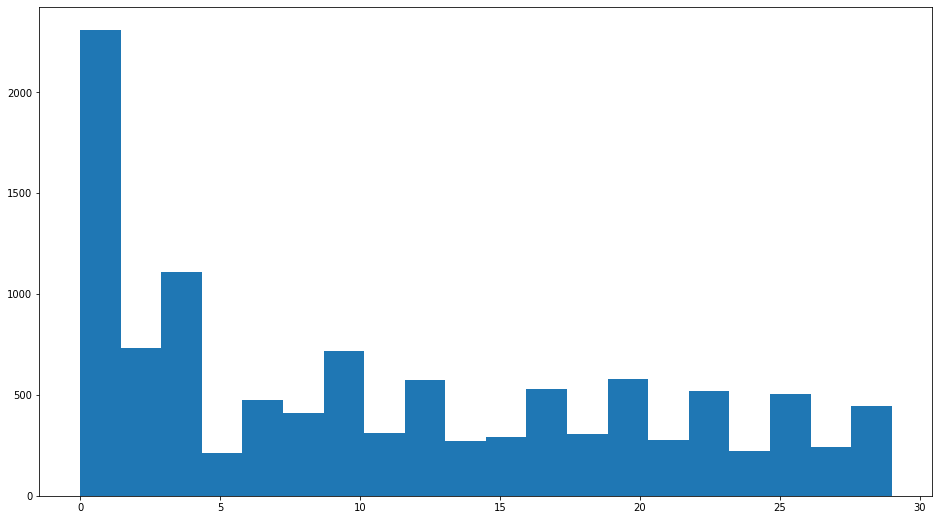

In [ ]:
plt.figure(figsize=(16,9))
plt.hist(recency_frequecy_data['Time'].astype('timedelta64[D]'),20,rwidth=1)
plt.show()

In [ ]:
recency_frequecy_data['Time'].head()

8593   29 days 23:54:25
2201   29 days 23:43:15
8376   29 days 23:32:04
8605   29 days 23:30:53
8178   29 days 23:29:35
Name: Time, dtype: timedelta64[ns]

# Api


In [ ]:
!pip install requests

In [ ]:
import requests
import json

In [ ]:
df['customer_id']=pd.to_numeric(df['customer_id'])

In [ ]:
"""customer_ids = df['customer_id']
for key,id in customer_ids:
  customer_ids[key]=int(id)"""

"customer_ids = df['customer_id']\nfor key,id in customer_ids:\n  customer_ids[key]=int(id)"

In [ ]:
df.shape[0]

4543

In [ ]:


a = "Hello, I am in grade "

b = 12

print("{}{}".format(a, b))

Hello, I am in grade 12


In [ ]:
df=df[300:]

In [ ]:
dfas.shape

(4243, 1)

{'id': 19427, 'createdAt': 1629900807399, 'updatedAt': 1629900807399, 'code': 'HAPPYSNACKER3', 'title': 'Extra snacking TODAY!', 'description': 'HAPPYSNACKER and get 30% off on all snacks', 'termsAndConditions': '', 'promotionId': 2, 'effectiveFrom': 1629900900000, 'expiredOn': 1629917940000, 'status': 'ACTIVE', 'ruleContext': {'customers': [200407, 200407, 200148, 199950, 199003, 198102, 196947, 190860, 190677, 190034, 189960, 186612, 186441, 185037, 184779, 181709, 176344, 172560, 168864, 164068, 161083, 160863, 160204, 159425, 158012, 156852, 156754, 156536, 151980, 147864, 144167, 141322, 136186, 134282, 130306, 125396, 123584, 123584, 121004, 115762, 115710, 115043, 111428, 109210, 107764, 107689, 104310, 102125, 99415, 99122, 96291, 96291, 91965, 91229, 82345, 78209, 74491, 51854, 50186, 50186, 42414, 24417, 179353, 188466, 115555, 189372, 181008, 123330, 181361, 182445, 175680, 185593, 28005, 185163, 24968, 16390, 6571, 15090, 164516, 22746, 21681, 164524, 197323, 141675, 195152

In [ ]:
response

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv('twentyFifth1.csv')
!cp twentyFifth1.csv "drive/My Drive/"

In [ ]:
response2.content

b'{"id":19495,"createdAt":1629974124758,"updatedAt":1629974124758,"code":"AbdullahTest","title":"Double the snacking this TWOS-DAY!","description":"HAPPYSNACKER and get 30% off on all snacks","termsAndConditions":"","promotionId":2,"effectiveFrom":1629974400000,"expiredOn":1629992400000,"status":"ACTIVE","ruleContext":{"customers":[203633],"serviceAreas":[],"discountPercentage":30,"maxPromoCodeUsageCount":1000,"maxPromoCodeUsageCountPerUser":1,"minOrderAmount":50.0,"maxDiscountPerOrder":200.0,"orderCountType":"WITH_OR_WITHOUT_PROMO"},"userVisibility":false,"notification":{"id":185,"createdAt":1629974124740,"title":"Double the snacking this TWOS-DAY!","body":"HAPPYSNACKER and get 30% off on all snacks","name":"HAPPYSNACKER","notificationType":2,"status":true}}'

In [ ]:
result2 = json.loads(response2.content)
print(result2)

{'id': 19495, 'createdAt': 1629974124758, 'updatedAt': 1629974124758, 'code': 'AbdullahTest', 'title': 'Double the snacking this TWOS-DAY!', 'description': 'HAPPYSNACKER and get 30% off on all snacks', 'termsAndConditions': '', 'promotionId': 2, 'effectiveFrom': 1629974400000, 'expiredOn': 1629992400000, 'status': 'ACTIVE', 'ruleContext': {'customers': [203633], 'serviceAreas': [], 'discountPercentage': 30, 'maxPromoCodeUsageCount': 1000, 'maxPromoCodeUsageCountPerUser': 1, 'minOrderAmount': 50.0, 'maxDiscountPerOrder': 200.0, 'orderCountType': 'WITH_OR_WITHOUT_PROMO'}, 'userVisibility': False, 'notification': {'id': 185, 'createdAt': 1629974124740, 'title': 'Double the snacking this TWOS-DAY!', 'body': 'HAPPYSNACKER and get 30% off on all snacks', 'name': 'HAPPYSNACKER', 'notificationType': 2, 'status': True}}


In [ ]:
result2

{'code': 'AbdullahTest',
 'createdAt': 1629974124758,
 'description': 'HAPPYSNACKER and get 30% off on all snacks',
 'effectiveFrom': 1629974400000,
 'expiredOn': 1629992400000,
 'id': 19495,
 'notification': {'body': 'HAPPYSNACKER and get 30% off on all snacks',
  'createdAt': 1629974124740,
  'id': 185,
  'name': 'HAPPYSNACKER',
  'notificationType': 2,
  'status': True,
  'title': 'Double the snacking this TWOS-DAY!'},
 'promotionId': 2,
 'ruleContext': {'customers': [203633],
  'discountPercentage': 30,
  'maxDiscountPerOrder': 200.0,
  'maxPromoCodeUsageCount': 1000,
  'maxPromoCodeUsageCountPerUser': 1,
  'minOrderAmount': 50.0,
  'orderCountType': 'WITH_OR_WITHOUT_PROMO',
  'serviceAreas': []},
 'status': 'ACTIVE',
 'termsAndConditions': '',
 'title': 'Double the snacking this TWOS-DAY!',
 'updatedAt': 1629974124758,
 'userVisibility': False}

In [ ]:
response

<Response [200]>